In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ================================

# Each user is responsible for checking the content of datasets and the
# applicable licenses and determining if suitable for the intended use.

# Building Session-Based Recommendation Models with Merlin

**Session-based recommendation (SBR)** has been an important task in online services like e-commerce and news portals, where users may have very distinct interests in different sessions. SBR models have been proposed to model the sequence of interactions within the current user session. They have gained popularity due to their ability to capture short-term or contextual user preferences towards items, and to provide promising model accuracy results. 


In this tutorial participants will learn: 
- the main concepts and algorithms for SBR
- how to process the data and create sequential features 
- how to create a SBR model starting with an MLP architecture, then with an RNN-based architecture and finally a Transformer-based one using NVIDIA Merlin 
- how to train & evaluate the models on GPU. 

## 1. Data Analysis & Preparation

**Learning Objectives**

- Analyze and prepare the train and validation datasets for feature engineering and transformation

### 1.1. Import Libraries

In [2]:
import os

import glob
import cudf 
import pandas as pd
import numpy as np
import nvtabular as nvt
from nvtabular.ops import *
import gc

from merlin.schema.tags import Tags
from merlin.io.dataset import Dataset

2023-02-14 00:03:51.670220: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")


### 1.2. Download Dataset

We are using [Booking.com dataset](https://github.com/bookingcom/ml-dataset-mdt) to train a session-based model. The raw train dataset contains 1,166,835 of anonymized hotel reservations given 217,686 unique trip ids made across 39,000 destinations. Each reservation is a part of a customer's trip (identified by utrip_id) which includes consecutive reservations. For more details, please refer to [Booking.com Multi-Destination Trips Dataset](https://dl.acm.org/doi/10.1145/3404835.3463240) published as a resource paper at SIGIR'21.

The main task is to use a dataset based on over a million of real anonymized accommodation reservations to come up with a strategy for making the best recommendation for travelers' next destination.

The goal is to create a DL model that can predict the `city_id` of the final reservation of each trip.

Let's start with defining the data path.

In [3]:
from merlin.core.dispatch import get_lib

DATA_FOLDER = os.environ.get(
    "DATA_FOLDER", 
    '/dli/task/data/'
)

Download the booking dataset via a utilitiy function.

In [4]:
from download_data import download_booking
download_booking(DATA_FOLDER)

downloading ground_truth.csv: 1.85MB [00:00, 171MB/s]                    
downloading test_set.csv: 29.2MB [00:00, 258MB/s]                            
downloading train_set.csv: 92.7MB [00:00, 391MB/s]                            


### 1.3. Analyze Dataset

We downloaded the dataset, now we can check out the training set.

In [58]:
import os
train = get_lib().read_csv(os.path.join(DATA_FOLDER, "train_set.csv"), parse_dates=['checkin', 'checkout'])

Each reservation has a unique `utrip_id`. During each trip a customer vists several destinations.

In [59]:
print(train.head())

   user_id    checkin   checkout  city_id device_class  affiliate_id  \
0  1000027 2016-08-13 2016-08-14     8183      desktop          7168   
1  1000027 2016-08-14 2016-08-16    15626      desktop          7168   
2  1000027 2016-08-16 2016-08-18    60902      desktop          7168   
3  1000027 2016-08-18 2016-08-21    30628      desktop           253   
4  1000033 2016-04-09 2016-04-11    38677       mobile           359   

  booker_country hotel_country   utrip_id  
0        Elbonia        Gondal  1000027_1  
1        Elbonia        Gondal  1000027_1  
2        Elbonia        Gondal  1000027_1  
3        Elbonia        Gondal  1000027_1  
4         Gondal  Cobra Island  1000033_1  


The training dataset consists of 1,166,835 of v hotel reservations, based on real data (fully anonymized), with the following features:

- user_id - User ID
- checkin - Reservation check-in date
- checkout - Reservation check-out date- created_date - Date when the reservation was made
- affiliate_id - An anonymized ID of affiliate channels where the booker came from (e.g. direct, some third party referrals, paid search engine, etc.)
- device_class - desktop/mobile
- booker_country - Country from which the reservation was made
- hotel_country - Country of the hotel 
- city_id - city_id of the hotel's city
- utrip_id - Unique identification of user's trip (a group of multi-destinations bookings within the same trip).

Check out the dtypes of the dataset.

In [60]:
train.dtypes

user_id                    int64
checkin           datetime64[ns]
checkout          datetime64[ns]
city_id                    int64
device_class              object
affiliate_id               int64
booker_country            object
hotel_country             object
utrip_id                  object
dtype: object

Check if data set has any nulls values.

In [61]:
train.isnull().any()

user_id           False
checkin           False
checkout          False
city_id           False
device_class      False
affiliate_id      False
booker_country    False
hotel_country     False
utrip_id          False
dtype: bool

#### Basic Stats

In [62]:
print(train.shape)

(1166835, 9)


In [63]:
train.utrip_id.nunique(), train.city_id.nunique(), train.user_id.nunique()

(217686, 39901, 200153)

Check min and max timestamp values.

In [ ]:
train.checkin.min(), train.checkin.max()

(numpy.datetime64('2015-12-31T00:00:00.000000000'),
 numpy.datetime64('2017-02-27T00:00:00.000000000'))

**Interactions per day**

In [ ]:
#!python -m pip install -U matplotlib

<Axes: xlabel='checkin'>

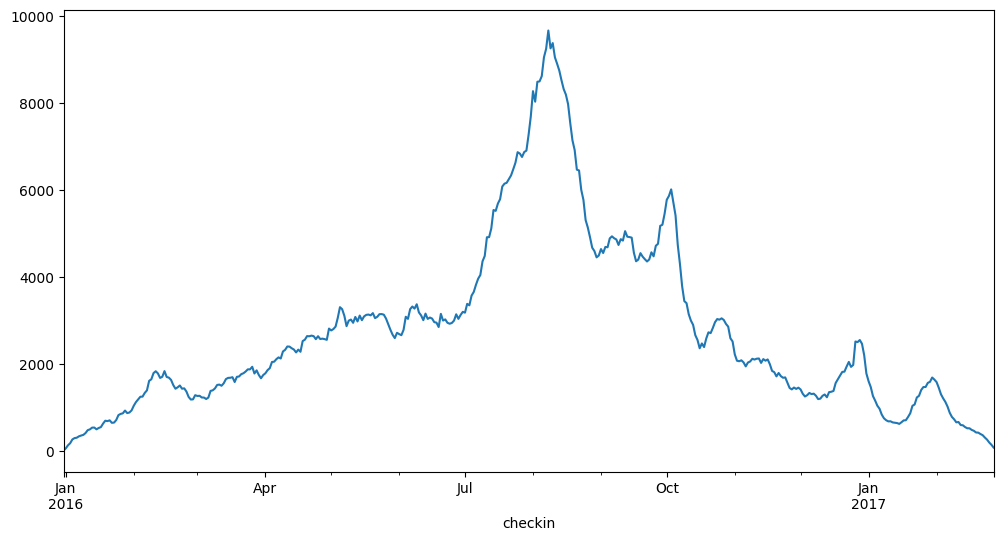

In [68]:
train.groupby('checkin').size().to_pandas().sort_index().plot.line(figsize=(12,6))

We see more trips between July-October time period.

### 1.4. Split the train set as train and validation sets

Let's split the data into a train and validation set based on checkin time, and trip id. We first sort the train dataset according to `checkin` date, and reserve the last two months as validation set.

In [11]:
train_set = train.sort_values(['checkin', 'utrip_id']).reset_index(drop=True)

Check if there are any duplicated (user, checkin) pairs.

In [12]:
train_set.to_pandas().duplicated(subset=['user_id', 'checkin']).sum()

0

Apply timebased split.

In [13]:
train = train_set[(train_set['checkin'] < pd.Timestamp("2017-01-01"))]
valid = train_set[(train_set['checkin'] >= pd.Timestamp("2017-01-01"))]

Print the shape of the tran and validation sets, and number of unique trip ids in each dataset.

In [14]:
train.shape, valid.shape

((1116574, 9), (50261, 9))

In [32]:
num_unique_trips_train,  num_unique_trips_valid= train.utrip_id.nunique(), valid.utrip_id.nunique()
print (num_unique_trips_train,  num_unique_trips_valid)

209342 10767


We can check the number of visits per trip per dataset, and find the percentage of the number of trips that have more than 30 visits. This shows that majority of the trips have less than 30 cities visited.

In [33]:
num_unique_trips= train.utrip_id.nunique()
((train.groupby('utrip_id')['city_id'].size()>30).sum() / num_unique_trips_train) *100

0.00907605736068252

We can also calculate the percentage of the trips that have only 1 city visited. 

In [ ]:
((train.groupby('utrip_id')['city_id'].size()<2).sum() / num_unique_trips_train) *100

0.2770585931155717

Similarly, we see that validation set does not have any trip that have more than 30 cities visited.

In [39]:
((valid.groupby('utrip_id')['city_id'].size()>30).sum()/ num_unique_trips_valid) *100

0.0

However, validation set has more trips that has only one city visited.

In [40]:
((valid.groupby('utrip_id')['city_id'].size()<2).sum() / num_unique_trips_valid) *100

8.405312529023869

Considering this, we can set the max sequence length to 30 in the next notebook where we will transform the datasets and create features.

Now, let's check out how many of the last visited city_id (target city) in the validation set are not in the train set. The reason we check this is because, when we encode validation set's city_id column in the next notebook, the city ids that are not seen train set will be mapped to `0`. We call them as out-of-vocabular (OOV) city ids. Since they are not in significant amount, in the next notebook we can remove the rows where city_id is `0` after encoding.

In [23]:
valid_grouped = valid.groupby('utrip_id')['city_id'].agg(['last']).reset_index()
valid_grouped[~valid_grouped['last'].isin(train.city_id)]

,utrip_id,last
98,1056954_1,33994
141,1077067_1,43849
222,1119551_3,10084
296,1157265_1,47263
318,1165937_2,42761
...,...,...
9659,6031094_1,33356
9699,6050318_1,59112
10363,787466_1,10396
10512,867686_1,33824


Save parquet files to disk.

In [ ]:
train.to_parquet(os.path.join(DATA_FOLDER, "train.parquet"))
valid.to_parquet(os.path.join(DATA_FOLDER, "valid.parquet"))

In [ ]:
del train, valid, train_set
gc.collect()

### Summary

In this notebook, we have done the following steps:
    
- download the dataset
- analyze the dataset
- split the dataset based on timestamp as train and validation sets
- save the train and validation sets to disk as parquet files

Please execute the cell below to shut down the kernel before moving on to the next notebook `02-ETL-with-NVTabular`.

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}